## Modelo de lenguaje con tokenización por caracteres

### Consigna

  Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.

  Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

  Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.

  Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

### Sugerencias

  Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.

  Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
  rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.



In [94]:
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from scipy.special import softmax

In [95]:

if not os.path.exists('./songs_dataset'):
    if not os.path.exists('songs_dataset.zip'):
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip



In [96]:
# Posibles bandas
os.listdir("./songs_dataset/")

['leonard-cohen.txt',
 'blink-182.txt',
 'r-kelly.txt',
 'bruce-springsteen.txt',
 'michael-jackson.txt',
 'paul-simon.txt',
 'kanye.txt',
 'notorious-big.txt',
 'nursery_rhymes.txt',
 'dj-khaled.txt',
 'al-green.txt',
 'lady-gaga.txt',
 'dr-seuss.txt',
 'eminem.txt',
 'disney.txt',
 'amy-winehouse.txt',
 'patti-smith.txt',
 'drake.txt',
 'bob-marley.txt',
 'Kanye_West.txt',
 'bjork.txt',
 'bieber.txt',
 'radiohead.txt',
 'bob-dylan.txt',
 'missy-elliott.txt',
 'bruno-mars.txt',
 'lil-wayne.txt',
 'beatles.txt',
 'jimi-hendrix.txt',
 'prince.txt',
 'lin-manuel-miranda.txt',
 'kanye-west.txt',
 'ludacris.txt',
 'nickelback.txt',
 'nicki-minaj.txt',
 'lorde.txt',
 'janisjoplin.txt',
 'Lil_Wayne.txt',
 'dickinson.txt',
 'notorious_big.txt',
 'alicia-keys.txt',
 'cake.txt',
 'rihanna.txt',
 'johnny-cash.txt',
 'dolly-parton.txt',
 'nirvana.txt',
 'joni-mitchell.txt',
 'britney-spears.txt',
 'adele.txt']

In [97]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/lady-gaga.txt', sep='/n', header=None)
df.head()

/tmp/ipython-input-4107314280.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/lady-gaga.txt', sep='/n', header=None)


,0
0,"I'll undress you, 'cause you're tired"
1,Cover you as you desire
2,When you fall asleep inside my arms
3,May not have the fancy things
4,But I'll give you everything


In [98]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 3807


### Elegir el tamaño del contexto

In [99]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [100]:
# cada verso lo guardamos en una lista
text = list(df[0])
text

["I'll undress you, 'cause you're tired",
 'Cover you as you desire',
 'When you fall asleep inside my arms',
 'May not have the fancy things',
 "But I'll give you everything",
 "You could ever want, it's in my arms So baby tell me yes",
 'And I will give you everything',
 'So baby tell me yes',
 'And I will be all yours tonight',
 'So baby tell me yes',
 'And I will give you everything',
 "I will be right by your side If I can't find the cure, I'll",
 "I'll fix you with my love",
 "No matter what you know, I'll",
 "I'll fix you with my love",
 "And if you say you're okay",
 "I'm gonna heal you anyway",
 "Promise I'll always be there",
 "Promise I'll be the cure (be the cure) Rub your feet, your hands, your legs",
 'Let me take care of it, babe',
 "Close your eyes, I'll sing your favorite song",
 'I wrote you this lullaby',
 "Hush now baby, don't you cry",
 'Anything you want could not be wrong So baby tell me yes',
 'And I will give you everything',
 'So baby tell me yes',
 'And I wil

In [101]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [102]:
# calculamos la longitud de cada secuencia
length_sentences = [len(s) for s in segmented_sentences]

Graficamos un histograma para obtener mas informacion respecto de la longitud de las secuencias.

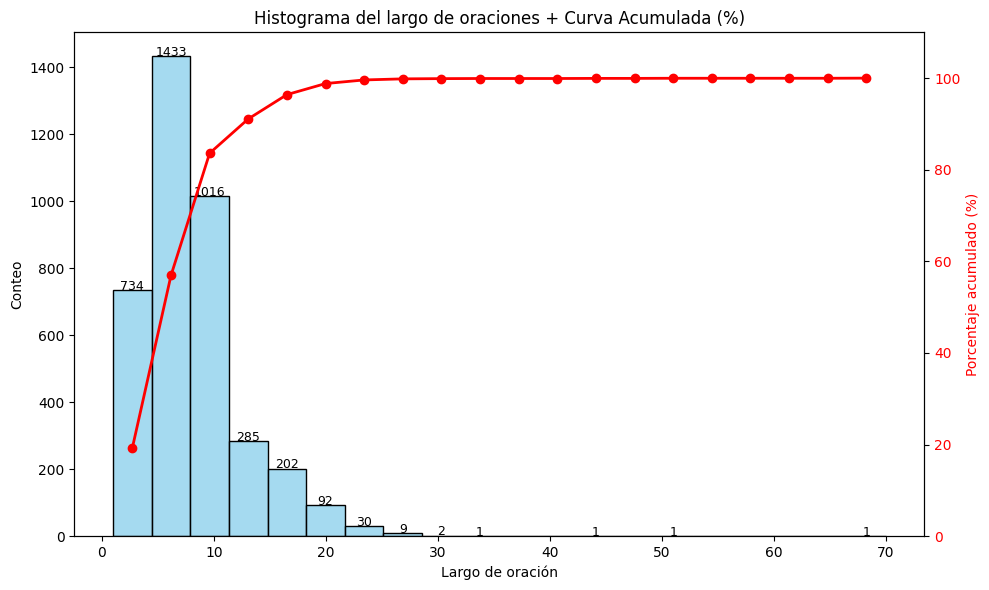

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculamos el histograma manualmente para obtener los datos
counts, bin_edges = np.histogram(length_sentences, bins=20)

# Calculamos el porcentaje acumulado
cum_counts = np.cumsum(counts)
cum_percent = cum_counts / cum_counts[-1] * 100     # en %

plt.figure(figsize=(10,6))

# ----- Histograma en Seaborn -----
ax = sns.histplot(length_sentences, bins=20, kde=False,
                  color="skyblue", edgecolor="black")

# Agregar los valores arriba de cada barra
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width()/2,
            height + 0.5,
            int(height),
            ha='center', fontsize=9
        )

# ----- Eje secundario para la curva acumulada -----
ax2 = ax.twinx()

# Centros de las barras
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Curva acumulada
ax2.plot(bin_centers, cum_percent, color="red", marker="o", linewidth=2, label="Acumulado (%)")
ax2.set_ylabel("Porcentaje acumulado (%)", color="red")
ax2.tick_params(axis='y', labelcolor="red")
ax2.set_ylim(0, 110)   # un poco más para que no corte

# ----- Etiquetas -----
ax.set_xlabel("Largo de oración")
ax.set_ylabel("Conteo")
ax.set_title("Histograma del largo de oraciones + Curva Acumulada (%)")

plt.tight_layout()
plt.show()


In [104]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)
# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 13


# Tokenizamos

In [105]:
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [106]:
tokenized_sentences

[[35, 826, 2, 61, 37, 827],
 [407, 2, 46, 2, 723],
 [56, 2, 297, 828, 244, 6, 580],
 [361, 38, 108, 3, 643, 232],
 [25, 35, 78, 2, 179],
 [2, 40, 408, 19, 52, 15, 6, 580, 32, 22, 81, 5, 264],
 [8, 1, 139, 78, 2, 179],
 [32, 22, 81, 5, 264],
 [8, 1, 139, 14, 55, 644, 105],
 [32, 22, 81, 5, 264],
 [8, 1, 139, 78, 2, 179],
 [1, 139, 14, 140, 343, 11, 502, 50, 1, 39, 214, 3, 198, 35],
 [35, 193, 2, 23, 6, 13],
 [44, 382, 27, 2, 31, 35],
 [35, 193, 2, 23, 6, 13],
 [8, 50, 2, 90, 37, 298],
 [10, 60, 383, 2, 581],
 [233, 35, 199, 14, 151],
 [233, 35, 14, 3, 198, 14, 3, 198, 582, 11, 829, 11, 137, 11, 830],
 [109, 5, 82, 323, 24, 17, 129],
 [645, 11, 155, 35, 468, 11, 583, 384],
 [1, 831, 2, 34, 982],
 [469, 106, 22, 18, 2, 143],
 [503, 2, 19, 40, 38, 14, 276, 32, 22, 81, 5, 264],
 [8, 1, 139, 78, 2, 179],
 [32, 22, 81, 5, 264],
 [8, 1, 139, 14, 55, 644, 105],
 [32, 22, 81, 5, 264],
 [8, 1, 139, 78, 2, 179],
 [1, 139, 14, 140, 343, 11, 502, 50, 1, 39, 214, 3, 198, 35],
 [35, 193, 2, 23, 6, 13]

In [107]:
vocab_size = len(tok.word_index)

In [108]:
max_context_size+1

14

### Organizando y estructurando el dataset

In [109]:
tokenized_sentences_train, tokenized_sentences_val = train_test_split(tokenized_sentences, test_size=0.2, random_state=42)


Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [110]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


AUmentamos la cantidad de datos generando subsecuencias

In [111]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [112]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [113]:
train_seqs.shape

(36631, 14)

In [114]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,-1]

In [115]:
# Palabras del vocabulario
tok.index_word

{1: 'i',
 2: 'you',
 3: 'the',
 4: 'a',
 5: 'me',
 6: 'my',
 7: 'to',
 8: 'and',
 9: 'oh',
 10: "i'm",
 11: 'your',
 12: 'that',
 13: 'love',
 14: 'be',
 15: 'in',
 16: 'on',
 17: 'it',
 18: "don't",
 19: 'want',
 20: 'just',
 21: 'eh',
 22: 'baby',
 23: 'with',
 24: 'of',
 25: 'but',
 26: 'we',
 27: 'what',
 28: 'wanna',
 29: 'like',
 30: 'do',
 31: 'know',
 32: 'so',
 33: 'is',
 34: 'this',
 35: "i'll",
 36: 'can',
 37: "you're",
 38: 'not',
 39: "can't",
 40: 'could',
 41: 'p',
 42: 'up',
 43: 'one',
 44: 'no',
 45: 'good',
 46: 'as',
 47: 'got',
 48: 'm',
 49: 'for',
 50: 'if',
 51: 'million',
 52: "it's",
 53: 'way',
 54: 'reasons',
 55: 'all',
 56: 'when',
 57: 'heart',
 58: 'hair',
 59: 'dance',
 60: 'gonna',
 61: "'cause",
 62: 'out',
 63: 'la',
 64: 'girl',
 65: 'show',
 66: 'ah',
 67: 'face',
 68: 'boys',
 69: 'need',
 70: 'muh',
 71: 'touch',
 72: 'yeah',
 73: 'he',
 74: 'was',
 75: 'body',
 76: 'come',
 77: 'ha',
 78: 'give',
 79: 'down',
 80: 'make',
 81: 'tell',
 82: 'tak

In [116]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2270

In [117]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'i': 1, 'you': 2, 'the': 3, 'a': 4, 'me': 5, 'my': 6, 'to': 7, 'and': 8, 'oh': 9, "i'm": 10, 'your': 11, 'that': 12, 'love': 13, 'be': 14, 'in': 15, 'on': 16, 'it': 17, "don't": 18, 'want': 19, 'just': 20, 'eh': 21, 'baby': 22, 'with': 23, 'of': 24, 'but': 25, 'we': 26, 'what': 27, 'wanna': 28, 'like': 29, 'do': 30, 'know': 31, 'so': 32, 'is': 33, 'this': 34, "i'll": 35, 'can': 36, "you're": 37, 'not': 38, "can't": 39, 'could': 40, 'p': 41, 'up': 42, 'one': 43, 'no': 44, 'good': 45, 'as': 46, 'got': 47, 'm': 48, 'for': 49, 'if': 50, 'million': 51, "it's": 52, 'way': 53, 'reasons': 54, 'all': 55, 'when': 56, 'heart': 57, 'hair': 58, 'dance': 59, 'gonna': 60, "'cause": 61, 'out': 62, 'la': 63, 'girl': 64, 'show': 65, 'ah': 66, 'face': 67, 'boys': 68, 'need': 69, 'muh': 70, 'touch': 71, 'yeah': 72, 'he': 73, 'was': 74, 'body': 75, 'come': 76, 'ha': 77, 'give': 78, 'down': 79, 'make': 80, 'tell': 81, 'take': 82, "i've": 83, 'were': 84, 'she': 85, 'read': 86, 'see': 87, "won't": 88, 'poker

In [118]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {"i'll": 136, "'cause": 92, 'tired': 3, 'undress': 3, 'you': 917, "you're": 133, 'as': 63, 'desire': 4, 'cover': 11, 'inside': 20, 'my': 565, 'fall': 16, 'arms': 6, 'asleep': 3, 'when': 101, 'the': 650, 'have': 50, 'things': 22, 'fancy': 5, 'not': 135, 'may': 13, 'everything': 22, 'give': 70, 'but': 187, 'so': 141, 'yes': 19, 'want': 204, 'baby': 200, "it's": 104, 'could': 111, 'tell': 67, 'in': 297, 'me': 571, 'ever': 11, 'will': 38, 'i': 900, 'and': 409, 'yours': 5, 'tonight': 39, 'be': 285, 'all': 101, "can't": 136, 'cure': 17, 'your': 334, 'right': 38, 'by': 14, 'find': 23, 'if': 109, 'side': 8, 'fix': 25, 'with': 208, 'love': 273, 'what': 154, 'matter': 12, 'know': 132, 'no': 115, 'okay': 16, 'say': 54, 'heal': 12, 'gonna': 93, "i'm": 350, 'anyway': 6, 'promise': 20, 'there': 34, 'always': 25, 'rub': 4, 'feet': 3, 'hands': 33, 'legs': 3, 'it': 244, 'babe': 42, 'take': 65, 'care': 11, 'of': 178, 'let': 50, 'sing': 9, 'eyes': 30, 'song': 12, 'favorite': 6,

In [119]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.squeeze(), dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.squeeze(), dtype=torch.long)

# Dataset y DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)



In [120]:
import math

def perplexity(loss_value: float) -> float:
    """Calcula perplexity a partir del valor de loss promedio."""
    try:
        return math.exp(loss_value)
    except OverflowError:
        return float('inf')

In [121]:
class TextModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=5, hidden_dim=64, num_classes=None, max_context_size=3):
        super(TextModel, self).__init__()

        # Embedding:
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=embed_dim)

        # LSTMs: el primero devuelve secuencia completa
        self.lstm1 = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, vocab_size+1)

    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)  # (batch, seq_len, embed_dim)

        # Primer LSTM: return_sequences=True equivale a quedarse con toda la salida
        x, _ = self.lstm1(x)   # (batch, seq_len, hidden_dim)
        x = self.dropout(x)

        # Segundo LSTM: sin return_sequences -> solo último estado oculto
        x, (h_n, c_n) = self.lstm2(x)  # x = (batch, seq_len, hidden_dim)
        x = h_n[-1]                    # último hidden state: (batch, hidden_dim)

        x = F.relu(self.fc1(x))
        logits = self.fc2(x)           # (batch, vocab_size+1)
        return logits

    def predict(self,x):
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

In [122]:
model = TextModel(vocab_size=vocab_size, embed_dim=5, hidden_dim=64, num_classes=vocab_size+1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [123]:
epochs = 30

# Historial de métricas
history = {
    "train_loss": [],
    "val_loss": [],
    "train_ppl": [],
    "val_ppl": [],
    "val_acc": []
}

for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()
    train_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)  # (batch, vocab_size+1)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    avg_train_loss = train_loss / len(train_ds)
    train_ppl = perplexity(avg_train_loss)

    # --- Validación ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    avg_val_loss = val_loss / len(val_ds)
    val_ppl = perplexity(avg_val_loss)
    val_acc = correct / total

    # Guardar métricas
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_ppl"].append(train_ppl)
    history["val_ppl"].append(val_ppl)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_ppl:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_ppl:.2f}"
          )

Epoch 1/30 | Train Loss: 6.1288 | Train PPL: 458.87 | Val Loss: 5.9124 | Val PPL: 369.59
Epoch 2/30 | Train Loss: 5.7987 | Train PPL: 329.86 | Val Loss: 5.8230 | Val PPL: 337.98
Epoch 3/30 | Train Loss: 5.6340 | Train PPL: 279.77 | Val Loss: 5.6597 | Val PPL: 287.05
Epoch 4/30 | Train Loss: 5.4393 | Train PPL: 230.29 | Val Loss: 5.4940 | Val PPL: 243.23
Epoch 5/30 | Train Loss: 5.2496 | Train PPL: 190.49 | Val Loss: 5.3582 | Val PPL: 212.35
Epoch 6/30 | Train Loss: 5.0726 | Train PPL: 159.59 | Val Loss: 5.2150 | Val PPL: 184.01
Epoch 7/30 | Train Loss: 4.9024 | Train PPL: 134.61 | Val Loss: 5.0967 | Val PPL: 163.47
Epoch 8/30 | Train Loss: 4.7607 | Train PPL: 116.83 | Val Loss: 4.9729 | Val PPL: 144.45
Epoch 9/30 | Train Loss: 4.6245 | Train PPL: 101.95 | Val Loss: 4.8697 | Val PPL: 130.28
Epoch 10/30 | Train Loss: 4.4904 | Train PPL: 89.16 | Val Loss: 4.7723 | Val PPL: 118.19
Epoch 11/30 | Train Loss: 4.3567 | Train PPL: 78.00 | Val Loss: 4.6669 | Val PPL: 106.37
Epoch 12/30 | Train L

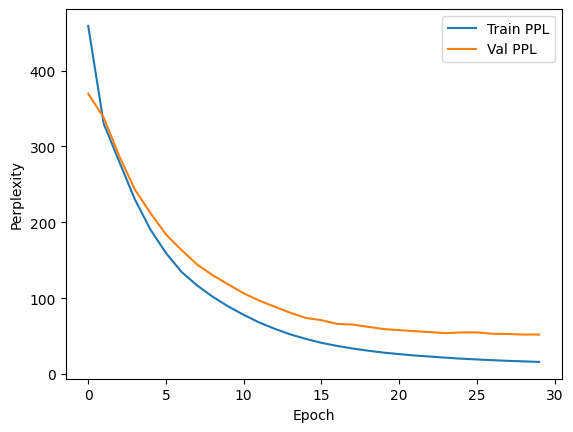

In [124]:
import matplotlib.pyplot as plt

plt.plot(history["train_ppl"], label="Train PPL")
plt.plot(history["val_ppl"], label="Val PPL")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.show()


# Conclusión

A lo largo de las 30 épocas de entrenamiento, el modelo mostró un proceso de aprendizaje consistente y progresivo. Tanto la función de pérdida como la perplexity disminuyeron de manera marcada durante las primeras etapas, lo que indica que el modelo logró capturar patrones relevantes del conjunto de entrenamiento. Paralelamente, la pérdida de validación acompañó esta tendencia, alcanzando sus mejores valores alrededor de las épocas 20 a 26, punto en el cual el desempeño comenzó a estabilizarse sin mejoras significativas posteriores.

Si bien se observa una brecha esperable entre las métricas de entrenamiento y validación, esta diferencia no evidencia un sobreajuste pronunciado, sino más bien una asintótica natural del aprendizaje. El comportamiento oscilante de la validación hacia el final del proceso sugiere que incrementar la cantidad de épocas no aportaría mejoras sustanciales, por lo que mecanismos como early stopping o la selección del modelo con menor pérdida de validación resultan recomendables.

En síntesis, el modelo logró un aprendizaje efectivo, redujo la perplexity de forma sostenida y alcanzó un nivel de generalización adecuado. Para futuras optimizaciones se recomienda explorar ajustes de hiperparámetros, técnicas de regularización o mejoras en la arquitectura, con el fin de reducir aún más la discrepancia entre entrenamiento y validación.

In [125]:
import torch

def predict_next_word(model, tokenizer, text, max_len, device="cpu"):
    model.eval()

    # Codificar texto a secuencia de índices
    encoded = tokenizer.texts_to_sequences([text])[0]

    # Padding/truncamiento manual
    if len(encoded) < max_len:
        encoded = [0] * (max_len - len(encoded)) + encoded
    else:
        encoded = encoded[-max_len:]

    # Convertir a tensor y mover a device
    x = torch.as_tensor([encoded], dtype=torch.long, device=device)

    with torch.no_grad():
        y_hat = model.forward(x)  # logits (1, vocab_size+1)

    # Índice de la palabra predicha
    idx = y_hat.argmax(dim=1).item()

    # Buscar la palabra en el tokenizer
    for word, i in tokenizer.word_index.items():
        if i == idx:
            return word
    return ""  # fallback si no encuentra

def generate_seq(model, tokenizer, seed_text, n_words, max_len, device="cpu"):
    output = seed_text
    for _ in range(n_words):
        next_word = predict_next_word(model, tokenizer, output, max_len, device)
        output += " " + next_word
    return output




In [126]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/

#!pip install -q gradio

In [127]:
"""
import gradio as gr

def model_response(human_text,device="cpu"):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    encoded_tens = torch.as_tensor(encoded, dtype=torch.long, device=device)

    y_hat = model.predict(encoded_tens).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)
"""

'\nimport gradio as gr\n\ndef model_response(human_text,device="cpu"):\n\n    # Encodeamos\n    encoded = tok.texts_to_sequences([human_text])[0]\n    # Si tienen distinto largo\n    encoded = pad_sequences([encoded], maxlen=max_context_size, padding=\'pre\')\n\n    # Predicción softmax\n    encoded_tens = torch.as_tensor(encoded, dtype=torch.long, device=device)\n\n    y_hat = model.predict(encoded_tens).argmax(axis=-1)\n\n    # Debemos buscar en el vocabulario la palabra\n    # que corresopnde al indice (y_hat) predicho por le modelo\n    out_word = \'\'\n    for word, index in tok.word_index.items():\n        if index == y_hat:\n            out_word = word\n            break\n\n    # Agrego la palabra a la frase predicha\n    return human_text + \' \' + out_word\n\niface = gr.Interface(\n    fn=model_response,\n    inputs=["textbox"],\n    outputs="text")\n\niface.launch(debug=True)\n'

In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=5, hidden_dim=64, num_classes=None, max_context_size=3):
        super(TextModel, self).__init__()

        if num_classes is None:
            num_classes = vocab_size + 1

        # Embedding:
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1,
                                      embedding_dim=embed_dim)

        # LSTMs: el primero devuelve secuencia completa
        self.lstm1 = nn.LSTM(input_size=embed_dim,
                             hidden_size=hidden_dim,
                             batch_first=True)

        # Segundo LSTM: también secuencia, usamos el último hidden
        self.lstm2 = nn.LSTM(input_size=hidden_dim,
                             hidden_size=hidden_dim,
                             batch_first=True)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        """
        x: (batch_size, seq_len) con índices de tokens
        devuelve logits: (batch_size, num_classes)
        """
        # (B, T, E)
        x = self.embedding(x)

        # Primer LSTM: secuencia completa
        x, _ = self.lstm1(x)              # x: (B, T, H)
        x = self.dropout(x)

        # Segundo LSTM: nos quedamos con el último hidden state
        x, (h_n, c_n) = self.lstm2(x)     # h_n: (1, B, H)
        x = h_n[-1]                       # (B, H)

        x = F.relu(self.fc1(x))
        logits = self.fc2(x)              # (B, num_classes)
        return logits

    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits, dim=1)


# LSTM

In [144]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Usando device:", device)

# Instanciamos el modelo (LSTM)
model = TextModel(
    vocab_size=vocab_size,
    embed_dim=5,
    hidden_dim=64,
    num_classes=vocab_size+1
).to(device)

criterion = nn.CrossEntropyLoss()

# Podés usar Adam o RMSprop (consigna sugiere RMSprop)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

epochs = 10  # o 20, lo que quieras

history = {
    "train_loss": [],
    "val_loss": [],
    "train_ppl": [],
    "val_ppl": [],
}

for epoch in range(epochs):
    # ---------- ENTRENAMIENTO ----------
    model.train()
    running_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        logits = model(X_batch)              # (B, vocab_size+1)
        loss = criterion(logits, y_batch)    # y_batch: (B,)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * X_batch.size(0)

    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_ppl = perplexity(avg_train_loss)

    # ---------- VALIDACIÓN ----------
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            running_val_loss += loss.item() * X_batch.size(0)

    avg_val_loss = running_val_loss / len(val_loader.dataset)
    val_ppl = perplexity(avg_val_loss)

    # Guardamos métricas
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_ppl"].append(train_ppl)
    history["val_ppl"].append(val_ppl)

    print(f"Epoch {epoch+1}/{epochs} "
          f"- Train Loss: {avg_train_loss:.4f}  PPL: {train_ppl:.2f} "
          f"- Val Loss: {avg_val_loss:.4f}  PPL: {val_ppl:.2f}")



Usando device: cuda
Epoch 1/10 - Train Loss: 6.0034  PPL: 404.82 - Val Loss: 5.8654  PPL: 352.64
Epoch 2/10 - Train Loss: 5.6889  PPL: 295.56 - Val Loss: 5.7103  PPL: 301.95
Epoch 3/10 - Train Loss: 5.4834  PPL: 240.65 - Val Loss: 5.5774  PPL: 264.38
Epoch 4/10 - Train Loss: 5.2566  PPL: 191.82 - Val Loss: 5.3642  PPL: 213.61
Epoch 5/10 - Train Loss: 4.9947  PPL: 147.63 - Val Loss: 5.1796  PPL: 177.61
Epoch 6/10 - Train Loss: 4.7234  PPL: 112.55 - Val Loss: 4.9933  PPL: 147.42
Epoch 7/10 - Train Loss: 4.4753  PPL: 87.82 - Val Loss: 4.8294  PPL: 125.13
Epoch 8/10 - Train Loss: 4.2497  PPL: 70.09 - Val Loss: 4.6955  PPL: 109.46
Epoch 9/10 - Train Loss: 4.0488  PPL: 57.33 - Val Loss: 4.5663  PPL: 96.19
Epoch 10/10 - Train Loss: 3.8724  PPL: 48.06 - Val Loss: 4.5101  PPL: 90.94


# GRU

In [141]:
class TextModelGRU(nn.Module):
    def __init__(self, vocab_size, embed_dim=5, hidden_dim=64, num_classes=None, max_context_size=3):
        super(TextModelGRU, self).__init__()

        if num_classes is None:
            num_classes = vocab_size + 1

        # Embedding
        self.embedding = nn.Embedding(num_embeddings=vocab_size + 1,
                                      embedding_dim=embed_dim)

        # GRU 1
        self.gru1 = nn.GRU(input_size=embed_dim,
                           hidden_size=hidden_dim,
                           batch_first=True)

        # GRU 2
        self.gru2 = nn.GRU(input_size=hidden_dim,
                           hidden_size=hidden_dim,
                           batch_first=True)

        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        """
        x: (batch_size, seq_len)
        """
        x = self.embedding(x)             # (B, T, E)

        x, h1 = self.gru1(x)              # x: (B, T, H)
        x = self.dropout(x)

        x, h2 = self.gru2(x)              # h2: (1, B, H)
        x = h2[-1]                        # (B, H)

        x = F.relu(self.fc1(x))
        logits = self.fc2(x)              # (B, num_classes)
        return logits

    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits, dim=1)


In [145]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model_gru = TextModelGRU(
    vocab_size=vocab_size,
    embed_dim=5,
    hidden_dim=64,
    num_classes=vocab_size + 1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model_gru.parameters(), lr=1e-3)


Device: cuda


In [146]:
epochs = 20  # o lo que quieras

history_gru = {
    "train_loss": [],
    "val_loss":   [],
    "train_ppl":  [],
    "val_ppl":    [],
}

for epoch in range(epochs):
    # --------- ENTRENAMIENTO ---------
    model_gru.train()
    running_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        logits = model_gru(X_batch)           # (B, vocab_size+1)
        loss = criterion(logits, y_batch)     # y_batch: (B,)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * X_batch.size(0)

    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_ppl = perplexity(avg_train_loss)

    # --------- VALIDACIÓN ---------
    model_gru.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model_gru(X_batch)
            loss = criterion(logits, y_batch)

            running_val_loss += loss.item() * X_batch.size(0)

    avg_val_loss = running_val_loss / len(val_loader.dataset)
    val_ppl = perplexity(avg_val_loss)

    history_gru["train_loss"].append(avg_train_loss)
    history_gru["val_loss"].append(avg_val_loss)
    history_gru["train_ppl"].append(train_ppl)
    history_gru["val_ppl"].append(val_ppl)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train PPL: {train_ppl:.2f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val PPL: {val_ppl:.2f}")


Epoch 1/20 | Train Loss: 5.9021 | Train PPL: 365.82 | Val Loss: 5.6813 | Val PPL: 293.32
Epoch 2/20 | Train Loss: 5.4115 | Train PPL: 223.96 | Val Loss: 5.3712 | Val PPL: 215.13
Epoch 3/20 | Train Loss: 4.9999 | Train PPL: 148.39 | Val Loss: 5.0397 | Val PPL: 154.43
Epoch 4/20 | Train Loss: 4.6076 | Train PPL: 100.24 | Val Loss: 4.7841 | Val PPL: 119.60
Epoch 5/20 | Train Loss: 4.2622 | Train PPL: 70.97 | Val Loss: 4.6088 | Val PPL: 100.37
Epoch 6/20 | Train Loss: 3.9755 | Train PPL: 53.28 | Val Loss: 4.4569 | Val PPL: 86.22
Epoch 7/20 | Train Loss: 3.7351 | Train PPL: 41.89 | Val Loss: 4.3483 | Val PPL: 77.35
Epoch 8/20 | Train Loss: 3.5264 | Train PPL: 34.00 | Val Loss: 4.2385 | Val PPL: 69.30
Epoch 9/20 | Train Loss: 3.3445 | Train PPL: 28.35 | Val Loss: 4.1480 | Val PPL: 63.31
Epoch 10/20 | Train Loss: 3.1858 | Train PPL: 24.19 | Val Loss: 4.1011 | Val PPL: 60.40
Epoch 11/20 | Train Loss: 3.0446 | Train PPL: 21.00 | Val Loss: 4.0818 | Val PPL: 59.25
Epoch 12/20 | Train Loss: 2.9245

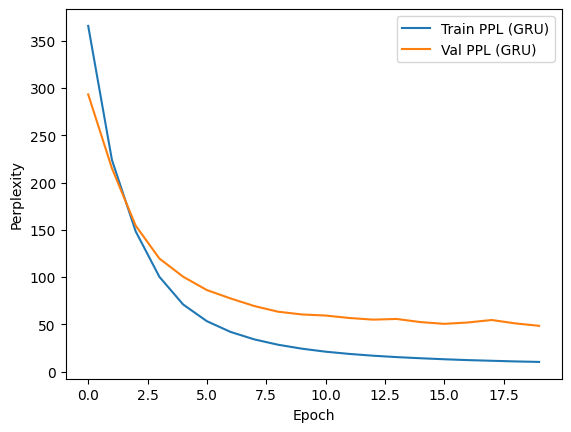

In [147]:
import matplotlib.pyplot as plt

plt.plot(history_gru["train_ppl"], label="Train PPL (GRU)")
plt.plot(history_gru["val_ppl"], label="Val PPL (GRU)")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.show()


# Generación de secuencias

Estrategia Greedy

In [132]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        encoded = torch.as_tensor(encoded, dtype=torch.long)
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [133]:
input_text='once upon a time'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=4)

'once upon a time spring spring spring spring'

Vamos a testear la generacion de secuencia con la estrategia Greedy Search

In [134]:
text[2]

'When you fall asleep inside my arms'

In [135]:
inputText="When you fall asleep"
generate_seq(model, tok, inputText, max_length=max_context_size, n_words=4)

'When you fall asleep spring spring spring spring'

# Nueva sección

###  Beam search y muestreo aleatorio

# Beam Search Stocastico

In [136]:
# funcionalidades para hacer encoding y decoding

def decode(seq):
    if isinstance(seq, torch.Tensor):
      # desconectar del grafo, mover a cpu, convertir a lista
      seq = seq.detach().cpu().tolist()
    return tok.sequences_to_texts([seq])[0]


def encode(text, tok=tok, max_length=max_context_size,device="cpu"):
    # Convertir texto a secuencia de enteros con tokenizer de Keras
    encoded = tok.texts_to_sequences([text])[0]  # lista de ints

    # Convertir a tensor long
    encoded = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)   # (1, seq_len)

    # Padding manual al inicio (equivale a 'pre' en Keras)
    if len(encoded) < max_length:
        pad_len = max_length - len(encoded)
        encoded = F.pad(encoded, (pad_len, 0), value=0)
    else:
        encoded = encoded[-max_length:]

    return encoded  # shape: (max_length,)

In [137]:
from scipy.special import softmax

# función que selecciona candidatos para el beam searchimport numpy as np
import torch
import torch.nn.functional as F

def select_candidates(preds, num_beams, vocab_size, history_probs, history_tokens, temp=1.0):
    """
    preds: lista de arrays (cada uno de shape [vocab_size]) con distribuciones de probabilidad
    history_probs: lista con log-probs acumuladas hasta ahora
    history_tokens: lista de secuencias de tokens
    """
    pred_large = []

    # aplanar todas las opciones posibles
    for idx, pp in enumerate(preds):
        # pp ya está en probs, convertimos a log-probs + acumulado
        pred_large.extend(np.log(pp + 1e-10) + history_probs[idx])

    pred_large = np.array(pred_large)

    # selección de candidatos
    # determinista:
    # idx_select = np.argsort(pred_large)[::-1][:num_beams]
    # estocástico:
    probs = np.exp(pred_large / temp)
    probs = probs / probs.sum()
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=probs)

    # traducir a índices de tokens
    new_history_tokens = np.concatenate(
        (np.array(history_tokens)[idx_select // vocab_size],
         np.array([idx_select % vocab_size]).T),
        axis=1
    )

    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_searchStoc(model, num_beams, num_words,input,temp=1.0,tok=tok, max_len=max_context_size,device="cpu"):
    model.eval()

    # encode texto inicial
    encoded = encode(input, tok, max_len)   # (seq_len,)
    encoded = encoded.to(device)    # (1, seq_len)

    with torch.no_grad():
        y_hat = model(encoded)                   # (1, vocab_size)
        y_hat = F.softmax(y_hat, dim=-1).cpu().numpy().squeeze()  # distribución inicial

    vocab_size = y_hat.shape[0]

    # inicialización
    history_probs = [0] * num_beams
    history_tokens = [encoded.cpu().numpy().flatten()] * num_beams

    # primera selección
    history_probs, history_tokens = select_candidates(
        [y_hat], num_beams, vocab_size, history_probs, history_tokens
    )

    # loop beam search
    for i in range(num_words - 1):
        preds = []

        for hist in history_tokens:
            input_update = torch.tensor(hist[-max_len:], dtype=torch.long, device=device).unsqueeze(0)

            with torch.no_grad():
                y_hat = model(input_update)          # (1, vocab_size)
                y_hat = F.softmax(y_hat, dim=-1).cpu().numpy().squeeze()

            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(
            preds, num_beams, vocab_size, history_probs, history_tokens,temp
        )

    return history_tokens


In [ ]:
# predicción con beam search
salidas = beam_searchStoc(model,num_beams=12,num_words=6,input='once upon a time',temp=2)
# veamos las salidas
decode(salidas[0])

In [ ]:
text[1]

# Beam Search Determinista

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

# ============================
# SELECT_CANDIDATES DETERMINISTA
# ============================
def select_candidates(preds, num_beams, vocab_size, history_probs, history_tokens):
    """
    Versión DETERMINISTA de selección de candidatos (beam search clásico).

    preds: lista de arrays (cada uno de shape [vocab_size]) con distribuciones de probabilidad
    history_probs: lista/array con log-probs acumuladas hasta ahora (len = num_beams)
    history_tokens: lista de secuencias de tokens (len = num_beams)
    """
    pred_large = []

    # aplanar todas las opciones posibles
    for idx, pp in enumerate(preds):
        # pp ya está en probs, convertimos a log-probs + acumulado
        pred_large.extend(np.log(pp + 1e-10) + history_probs[idx])

    pred_large = np.array(pred_large)  # shape: (num_beams * vocab_size,)

    # ==============================
    # SELECCIÓN DETERMINISTA (TOP-k)
    # ==============================
    # tomamos los índices de los num_beams MEJORES scores
    idx_select = np.argsort(pred_large)[::-1][:num_beams]

    history_tokens_arr = np.array(history_tokens)

    # traducir a índices de tokens y actualizar secuencias
    new_history_tokens = np.concatenate(
        (
            history_tokens_arr[idx_select // vocab_size],
            np.array([idx_select % vocab_size]).T
        ),
        axis=1
    )

    # devolvemos los log-probs seleccionados y las nuevas secuencias
    return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


# ============================
# BEAM SEARCH DETERMINISTA
# ============================
def beam_search(model, num_beams, num_words, input,
                tok, max_len, device="cpu"):
    model.eval()

    # encode texto inicial
    encoded = encode(input, tok, max_len)   # (seq_len,)
    encoded = encoded.to(device)            # (seq_len,) en device

    # aseguramos dimensión batch: (1, seq_len)
    if encoded.dim() == 1:
        encoded = encoded.unsqueeze(0)

    with torch.no_grad():
        y_hat = model(encoded)                   # (1, vocab_size)
        y_hat = F.softmax(y_hat, dim=-1).cpu().numpy().squeeze()  # (vocab_size,)

    vocab_size = y_hat.shape[0]

    # inicialización
    history_probs = np.zeros(num_beams, dtype=np.float32)
    base_seq = encoded.cpu().numpy().flatten()
    history_tokens = [base_seq.copy() for _ in range(num_beams)]

    # primera selección
    history_probs, history_tokens = select_candidates(
        [y_hat], num_beams, vocab_size, history_probs, history_tokens
    )

    # loop beam search
    for _ in range(num_words - 1):
        preds = []

        for hist in history_tokens:
            input_update = torch.tensor(
                hist[-max_len:], dtype=torch.long, device=device
            ).unsqueeze(0)

            with torch.no_grad():
                y_hat = model(input_update)          # (1, vocab_size)
                y_hat = F.softmax(y_hat, dim=-1).cpu().numpy().squeeze()

            preds.append(y_hat)

        history_probs, history_tokens = select_candidates(
            preds, num_beams, vocab_size, history_probs, history_tokens
        )

    return history_tokens, history_probs


In [ ]:
num_beams = 5
num_words = 10
seed = "once upon a time"

tokens, scores = beam_search(
    model,
    num_beams=num_beams,
    num_words=num_words,
    input=seed,
    tok=tok,
    max_len=max_context_size,
    device="cpu"
)

best_idx = scores.argmax()
best_seq = tokens[best_idx]

# si tenés una función decode:
# best_text = decode(best_seq, tok)
# print(best_text)


In [ ]:
decode(tokens[0])

# Conclusión
En este trabajo se desarrolló un modelo de lenguaje basado en tokenización por caracteres, utilizando un corpus de letras de canciones. El preprocesamiento incluyó la segmentación del texto, la construcción del vocabulario, la generación de secuencias de contexto y la división del dataset en entrenamiento y validación.

Para modelar dependencias temporales se implementaron redes neuronales recurrentes, comenzando con un modelo basado en LSTM y extendiendo luego el análisis a una GRU, que introduce puertas de actualización y reinicio, permitiendo manejar información de largo plazo con menor costo computacional. Ambas arquitecturas demostraron ser adecuadas para aprender patrones secuenciales complejos, siendo la GRU una alternativa más liviana y con tiempos de entrenamiento más rápidos.

El entrenamiento se guió mediante la pérdida de entropía cruzada y su métrica asociada, la perplejidad, que permitió evaluar la calidad del modelo y detectar el punto donde comenzaron a disminuir las mejoras significativas. El uso de RMSprop y Adam permitió una convergencia estable.

Para la etapa de generación, se implementaron tres estrategias de decodificación:

Greedy Search, que selecciona siempre el carácter de mayor probabilidad, generando secuencias coherentes pero poco diversas.

Beam Search determinístico, que mantiene varios caminos candidatos y permite obtener secuencias globalmente más probables.

Beam Search estocástico con temperatura, donde la variación de la temperatura controla el balance entre coherencia (temperaturas bajas) y creatividad/diversidad (temperaturas altas).

Los resultados muestran que las estrategias de búsqueda y la temperatura influyen directamente en el tipo y la calidad del texto generado, permitiendo explorar distintos estilos según los objetivos del usuario.

En síntesis, el pipeline construido permitió comprender en profundidad el proceso completo: desde la preparación del corpus y el entrenamiento de modelos recurrentes hasta la generación de texto con técnicas avanzadas de decodificación. El trabajo logró desarrollar modelos funcionales, evaluar su desempeño y analizar el impacto de la temperatura y del tamaño del beam sobre la calidad de la generación.